In [ ]:
%%capture
!pip install pillow

In [3]:
import warnings 
import requests
import numpy as np 
import pandas as pd
from PIL import Image
import tensorflow as tf 
from collections import defaultdict
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model ,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16 , EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Conv2D,Dropout,MaxPool2D,BatchNormalization,Input,Flatten,GlobalAveragePooling2D

warnings.filterwarnings("ignore")

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
%%capture
!kaggle datasets download -d msambare/fer2013
!kaggle datasets download -d musicblogger/spotify-music-data-to-identify-the-moods

In [5]:
%%capture
!unzip /content/fer2013.zip
!unzip /content/spotify-music-data-to-identify-the-moods.zip

In [5]:
data=pd.read_csv('/content/data_moods.csv')
data.head()

,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood
0,1999,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,1982-10-27,68,379266,0.866,0.13700,0.730,0.000000,0.0843,0.625,-8.201,0.0767,118.523,5,4,Happy
1,23,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,2007-04-16,43,318800,0.381,0.01890,0.832,0.196000,0.1530,0.166,-5.069,0.0492,120.255,8,4,Sad
2,9 Crimes,9,Damien Rice,5GZEeowhvSieFDiR8fQ2im,2006-11-06,60,217946,0.346,0.91300,0.139,0.000077,0.0934,0.116,-15.326,0.0321,136.168,0,4,Sad
3,99 Luftballons,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,1984-08-21,2,233000,0.466,0.08900,0.438,0.000006,0.1130,0.587,-12.858,0.0608,193.100,4,4,Happy
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,47IWLfIKOKhFnz1FUEUIkE,2004-01-01,60,268000,0.419,0.00171,0.932,0.000000,0.1370,0.445,-3.604,0.1060,169.881,1,4,Energetic


In [6]:
data=data[['name','mood']]

In [7]:
vgg = EfficientNetB7(weights="imagenet",include_top=False ,input_shape=(72,72,3),pooling="avg")

In [8]:
for layer in vgg.layers[-6:] :
  layer.trainable = True
x = vgg.output
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
predictions = Dense(512,activation="relu",kernel_regularizer=regularizers.l2(0.0001))(x)
predictions= BatchNormalization()(predictions)
predictions = Dropout(0.25)(predictions)
predictions = Dense(128,activation="relu",kernel_regularizer=regularizers.l2(0.0001))(predictions)
predictions = BatchNormalization()(predictions)
predictions = Dropout(0.25)(predictions)
predictions = Dense(7,activation="softmax")(predictions)
model_VGG = Model(vgg.input,predictions)

model_VGG.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),loss=\
                [tf.keras.losses.CategoricalCrossentropy()],metrics=["accuracy"])

In [9]:
val_generator = ImageDataGenerator(rescale=1/255)

train_generator = ImageDataGenerator(rescale = 1/255,
                                  zoom_range=0.3,
                                  shear_range=0.3,
                                  horizontal_flip=True,
                                  rotation_range=30,
                                  fill_mode="nearest")


In [10]:
val_data = val_generator.flow_from_directory("/content/test",
                                             batch_size= 64,
                                             target_size=(72,72),
                                             color_mode="rgb",
                                             interpolation="nearest")
train_data = train_generator.flow_from_directory("/content/train",
                                          batch_size= 64,
                                          target_size=(72,72),
                                          color_mode="rgb",
                                          interpolation="nearest")

Found 7178 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


In [11]:
vgg_step = ModelCheckpoint("vgg_step1.h5",monitor="val_accuracy",mode="max",save_best_only=True,\
                            save_weights_only=True,verbose=1)


In [12]:
model_VGG.fit(train_data,validation_data=val_data,epochs=1,callbacks=[vgg_step])

449/449 [==============================] - 577s 1s/step - loss: 2.6196 - accuracy: 0.1880 - val_loss: 2.1367 - val_accuracy: 0.1793

Epoch 00001: val_accuracy improved from -inf to 0.17930, saving model to vgg_step1.h5


#Now predict a new image

In [62]:
img = Image.open(requests.get('https://image.shutterstock.com/image-photo/close-portrait-smiling-handsome-man-260nw-1011569245.jpg', stream=True).raw)
image = img.resize((72,72))
image = np.array(resized_image).reshape(1,72,72,3)

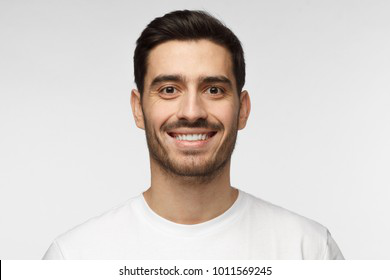

In [63]:
img

In [67]:
prediction=model_VGG.predict(image)
mood = np.where(prediction == np.amax(prediction))[1][0]

In [68]:
#Here i apply technique from my own logic on base of people like to listen what type of song according to their mood

if mood == 0:
  song = data.loc[data.mood == 'Happy'].sample().name.tolist()[0]
elif  mood == 1:
  song = data.loc[data.mood == 'Happy'].sample().name.tolist()[0]
elif  mood == 2:
  song = data.loc[data.mood == 'Calm'].sample().name.tolist()[0]
elif  mood == 3:
  song = data.loc[data.mood == 'Calm'].sample().name.tolist()[0]
elif  mood == 4:
  song = data.loc[data.mood == 'Sad'].sample().name.tolist()[0]
elif  mood == 5:
  song = data.loc[data.mood == 'Energetic'].sample().name.tolist()[0]
else:
  song = data.sample().name.tolist()[0]


In [66]:
moods = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [70]:
print('Mood is {0} \nAnd suggested son is {1}'.format(moods[mood],song))

Mood is Surprise 
And suggested son is Anthem of Our Dying Day
